# Clash of Clans battle outcome forecasting

This Notebook reads in the json files generated by clashcast.ipynb and generates catboost models on top

First we read in the json files and create a pandas data frame from them

In [59]:
import os
import json
import glob
import pandas as pd

data = []

for file in glob.glob("clanwars/*.json"):
    with open(file, "r") as f:
        c = json.loads(f.read())
        data += c
                 
print(f"Read {len(data)} data points")
df = pd.DataFrame(data)
df.head()

Read 254069 data points


,attackerTag,defenderTag,stars,destructionPercentage,order,duration,attacker_townHallLevel,attacker_expLevel,attacker_trophies,attacker_bestTrophies,...,attacker_troop_Battle_Drill_level,attacker_troop_Electro_Titan_level,attacker_troop_Phoenix_level,attacker_troop_Poison_Lizard_level,attacker_troop_Diggy_level,defender_troop_Battle_Drill_level,defender_troop_Frosty_level,defender_troop_Phoenix_level,defender_troop_Poison_Lizard_level,defender_troop_Diggy_level
0,#QJUCV989Q,#LVP9V20C0,1,60,1,123,9,42,920,902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#QJUCV989Q,#92PQCC2PG,0,37,2,69,9,42,920,902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#QCQPCU2PC,#LVP9V20C0,2,65,3,100,9,44,952,950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#L2U9QV0LJ,#LQC2YC0UP,1,64,4,124,13,149,2523,3099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#LQUPU82L9,#QY0YJCQLJ,1,68,5,134,11,130,2364,2651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


drop columns which we dont want for forecasting. We are using stars as multi class classification target so the destructionPercentage must be dropped

In [60]:
df_dropped = df.drop(labels=["attackerTag", "defenderTag", "order", "duration", "destructionPercentage", "attacker_warPreference", "defender_warPreference"], axis=1)
df_dropped.head()

,stars,attacker_townHallLevel,attacker_expLevel,attacker_trophies,attacker_bestTrophies,attacker_warStars,attacker_attackWins,attacker_defenseWins,attacker_builderHallLevel,attacker_versusTrophies,...,attacker_troop_Battle_Drill_level,attacker_troop_Electro_Titan_level,attacker_troop_Phoenix_level,attacker_troop_Poison_Lizard_level,attacker_troop_Diggy_level,defender_troop_Battle_Drill_level,defender_troop_Frosty_level,defender_troop_Phoenix_level,defender_troop_Poison_Lizard_level,defender_troop_Diggy_level
0,1,9,42,920,902,72,5,4,5,1381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,9,42,920,902,72,5,4,5,1381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,9,44,952,950,73,3,1,5,1214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,13,149,2523,3099,1658,1,16,7,2537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,11,130,2364,2651,835,3,3,8,2622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I tried different ways to deal with the categorical columns, using the catboost internal mechanism seems to work the best

In [18]:
df_dropped['defender_league'].head()

0      Silver League I
1        Gold League I
2      Silver League I
3    Master League III
4                 none
Name: defender_league, dtype: object

In [19]:
# we have two categorical columns: attacker_league and defender_league which need encoding

# leagues = list(df_dropped['attacker_league'].unique())

# def league_encoding(row, leagues):
#     row['defender_league_encoded'] = leagues.index(row['defender_league'])
#     row['attacker_league_encoded'] = leagues.index(row['attacker_league'])
#     return row

# df_encoded = df_dropped.apply(lambda row: league_encoding(row, leagues), axis=1).drop(labels=['attacker_league', 'defender_league'], axis=1)

# df_encoded.head()
df_encoded = df_dropped
cat_features = ['attacker_league', 'defender_league']


First model is a classifier. It allows us to make a single prediction per battle

In [20]:
from catboost import CatBoostClassifier

split_i = int(df_encoded.shape[0] * 0.7)
train = df_encoded.iloc[:split_i]
test = df_encoded.iloc[split_i:]
train_data = train.drop(labels=['stars'], axis=1)
train_labels = train['stars']
test_data = test.drop(labels=['stars'], axis=1)
test_labels = test['stars']
model = CatBoostClassifier(iterations=100000)
model_name = "classification.cbm"
if not os.path.exists(model_name):
    model.fit(train_data, train_labels, cat_features=cat_features, eval_set=(test_data, test_labels), early_stopping_rounds=10, verbose=False)
    model.save_model(model_name)
else:
    model.load_model(model_name)

In [21]:
matches = 0

for i in range(test_data.shape[0]):
    if model.predict(test_data.iloc[i]) == test_labels.iloc[i]:
        matches += 1
print(f"Accuracy of single classification model {matches / test_data.shape[0]}")

Accuracy of single classification model 0.6368323690321565


The second model is actually a set of 4 models each predicting the probability to reach a certain star outcome. it is much more useful to generate clan war strategies

In [22]:
from catboost import CatBoostRegressor

models = []

def to_float(val, stars):
    if val == stars:
        return 1.0
    return 0.0

for stars in [0, 1, 2, 3]:
    print(f"fitting {stars}")
    train_labels_mod = train_labels.apply(lambda val: to_float(val, stars))
    test_labels_mod = test_labels.apply(lambda val: to_float(val, stars))
    model = CatBoostRegressor(iterations=100000)
    model_name = f"stars_regression_{stars}.cbm"
    if not os.path.exists(model_name):
        model.fit(train_data, train_labels_mod, cat_features=cat_features, eval_set=(test_data, test_labels_mod), early_stopping_rounds=10, verbose=False)
        model.save_model(model_name)
    else:
        model.load_model(model_name)
    models.append(model)

fitting 0
fitting 1
fitting 2
fitting 3


In order to be able to reuse the model we also have to save the columns in the right order in which the model was trained

In [135]:
import json

with open("columns.json", "w") as f:
    f.write(json.dumps([column for column in train_data.columns]))

In [28]:
matches = 0

for i in range(test_data.shape[0]):
    denum = 0
    num = 0
    for star in [0, 1, 2, 3]:
        pred = models[star].predict(test_data.iloc[i])
        denum += pred
        if int(star) == int(test_labels.iloc[i]):
            num += pred
    # print(f"{model.predict(train_data.iloc[i])} - {train_labels[i]}")
print(f"{num / denum}")

0.3055385513469404


The accuracy of the classification model is superior, but it is much less versatile when we want to come up with a clan war strategy

Text(0.5, 1.0, 'Feature Importance')

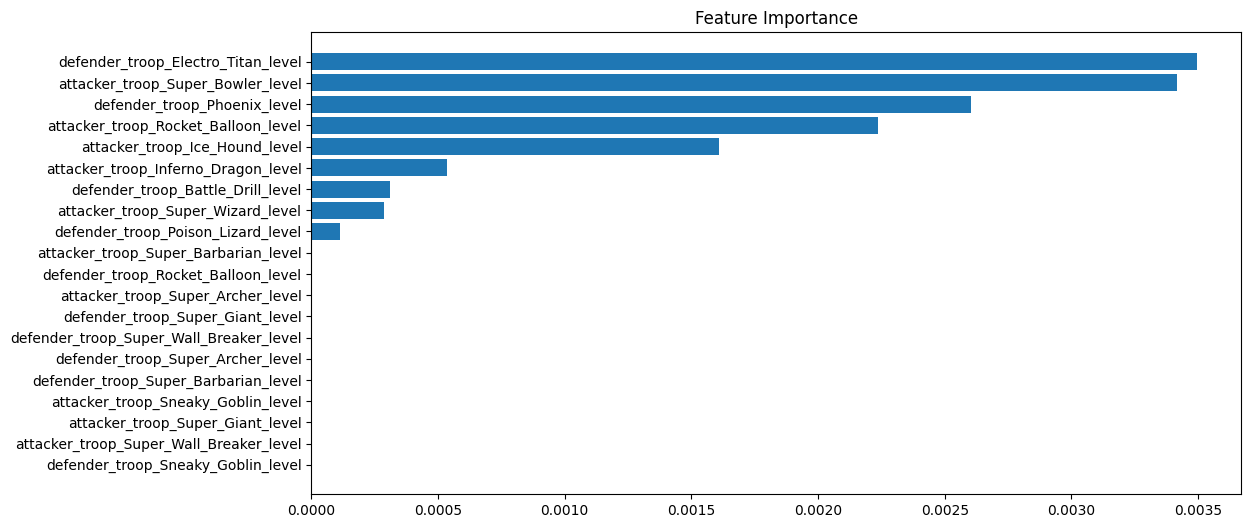

In [141]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = models[3].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx[:20])), feature_importance[sorted_idx[:20]], align='center')
plt.yticks(range(len(sorted_idx[:20])), np.array(train_data.columns)[sorted_idx[:20]])

plt.title('Feature Importance')


NameError: name 'X_test' is not defined

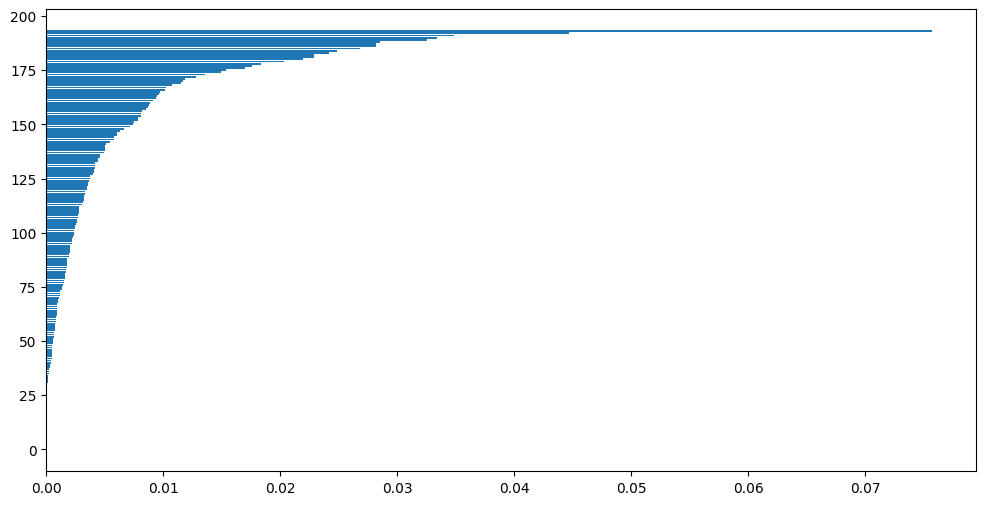

In [144]:
import shap

explainer = shap.Explainer(models[3])
shap_values = explainer(train_data)
shap_importance = shap_values.abs.mean(0).values


Text(0.5, 1.0, 'SHAP Importance')

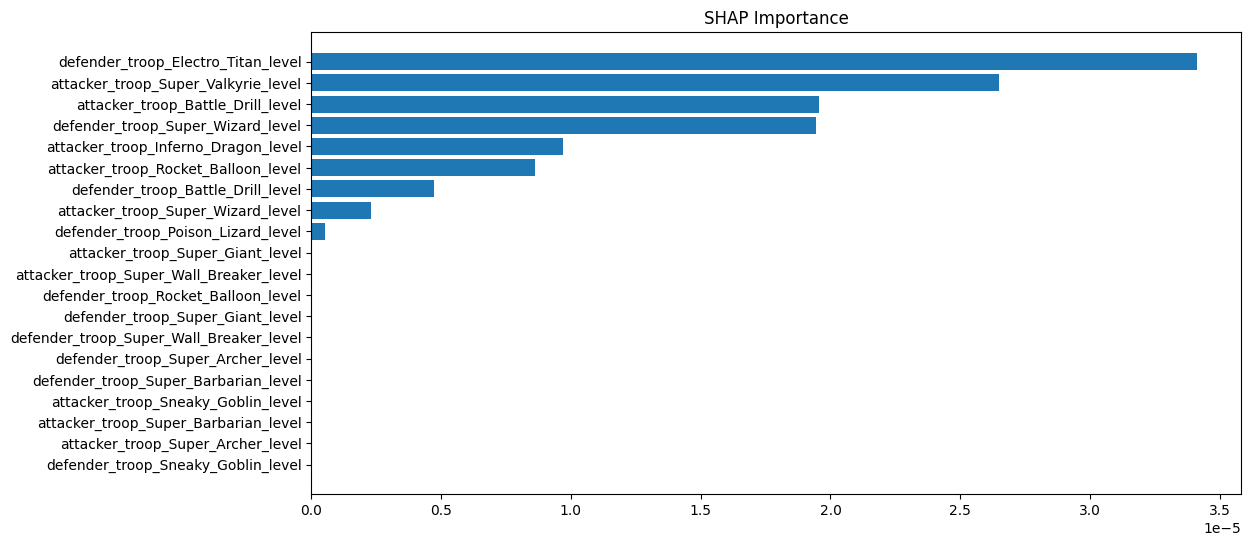

In [145]:
sorted_idx = shap_importance.argsort()[:20]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_data.columns)[sorted_idx])
plt.title('SHAP Importance')


Its quite interesting how the Electro Titan Level is the most important feature. Having at least one level here probably differentiates high level players from the rest.

## Building the inference model

We are now using the previously trained models to build an inference model

In [132]:
# forecast all possible outcomes of a clan war


import requests
import os


header = {"Authorization": f"Bearer {os.getenv('CLASH_OF_CLANS_KEY')}"}

mytag = '#Q8P2JR020'
myclan = '#2L8L9RLYU'

url = "https://api.clashofclans.com/v1"


In [131]:
class CoCForecaster:
    def __init__(self, models, api_key, sorted_columns):
        self.api_key = api_key
        self.models = models
        self.player_infos = dict()
        self.header = {"Authorization": f"Bearer {api_key}"}
        self.sorted_columns = sorted_columns
        
    def get_player_info(self, player_tag):
        if player_tag in self.player_infos.keys():
            return self.player_infos[player_tag]
        response = requests.get(f"https://api.clashofclans.com/v1/players/%23{player_tag.replace('#', '')}", headers=self.header)
        player_info = dict()
        for key in ["townHallLevel", "expLevel", "trophies", "bestTrophies", "warStars", "attackWins", "defenseWins", "builderHallLevel", "versusTrophies", "bestVersusTrophies", "versusBattleWins", "warPreference", "donations", "donationsReceived", "clanCapitalContributions"]: 
            player_info[key] = response.json().get(key, 0)
        if "league" in response.json().keys():
            player_info["league"] = response.json()["league"]["name"]
        else:
            player_info["league"] = "none"
        for troop in response.json()['troops']:
            key = f"troop_{troop['name'].replace(' ', '_')}_level"
            player_info[key] = troop['level']
        for hero in response.json()['heroes']:
            key = f"hero_{hero['name'].replace(' ', '_')}_level"
            player_info[key] = hero['level']
        for spell in response.json()['spells']:
            key = f"spell_{spell['name'].replace(' ', '_')}_level"
            player_info[key] = spell['level']
        player_infos[player_tag] = player_info
        return player_info
        
    def get_star_probability(self, attacker_tag, defender_tag):
        attacker_info = self.get_player_info(attacker_tag)
        defender_info = self.get_player_info(defender_tag)
        row = []
        for column in self.sorted_columns:
            if column.startswith("attacker_"):
                key = column.replace("attacker_", "")
                row.append(attacker_info.get(key))
            if column.startswith("defender_"):
                key = column.replace("defender_", "")
                row.append(attacker_info.get(key))
        stars = [self.models[0].predict([row]), self.models[1].predict([row]), self.models[2].predict([row]), self.models[3].predict([row])]
        # remove negative probabilities
        for i in range(len(stars)):
            if stars[i] < 0:
                stars[i] = 0
        # normalize the vector to sum to 1
        stars = stars / sum(stars)
        return [stars[0][0], stars[1][0], stars[2][0], stars[3][0]]
    
forecaster = CoCForecaster(models, os.getenv('CLASH_OF_CLANS_KEY'), train_data.columns)

print(f"The probabilities to defeat myself are: {forecaster.get_star_probability(mytag, mytag)}")

[[0.03097994]
 [0.18260596]
 [0.12935445]
 [0.65705965]]
The probabilities to defeat myself are: [0.03097994132830664, 0.18260596307053975, 0.12935444898339504, 0.6570596466177585]
